# Installing requirements 

`pip install -r requirements.txt`

# Imports and connections

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datasets import load_dataset
import statsmodels.api as sm

# Data load

In [153]:
dataset = load_dataset("gvlassis/california_housing")
dataset

DatasetDict({
    train: Dataset({
        features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'],
        num_rows: 16640
    })
    validation: Dataset({
        features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'],
        num_rows: 2000
    })
})

Датасет содержит набор данных о жилищном фонде Калифорнии из переписи населения Калифорнии 1997 года. Он содержит следующие характеристики:

- MedInc: Средний доход людей, проживающих в этом районе
- HouseAge: Средний возраст домов в этом районе
- AveRooms: Среднее количество комнат в домах в квартале
- AveBedrms: Среднее количество спален в домах в квартале
- Population: Количество людей, проживающих в квартале
- AveOccup: Среднее количество жителей, проживающих под одной крышей
- Latitude: Широта
- Longitude: Долгота
- MedHouseVal: целевая переменная, средняя стоимость дома

In [154]:
dataset = dataset["train"].to_pandas()
dataset.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000
mean,3.797641,29.221995,5.396218,1.101687,1436.939123,3.007617,35.267714,-119.146628,2.018484
std,1.867145,12.797845,2.648682,0.511507,1159.762831,5.114548,2.086404,1.923576,1.132658
min,0.499900,1.000000,0.846154,0.375000,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.526300,19.000000,4.379310,1.007401,792.000000,2.425249,33.870000,-121.240000,1.183000
50%,3.474500,30.000000,5.166053,1.050725,1168.000000,2.831033,34.100000,-118.300000,1.736000
75%,4.635475,38.000000,6.000000,1.101127,1727.000000,3.309981,37.710000,-117.890000,2.530250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,599.714286,41.950000,-114.310000,5.000010


In [155]:
dataset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [156]:
dataset.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
16635,4.9359,15.0,6.525316,1.034810,781.0,2.471519,35.30,-120.84,3.177
16636,2.5172,16.0,6.150470,1.095611,1325.0,2.076803,35.31,-120.82,2.939
16637,3.5870,20.0,6.027397,1.076712,996.0,2.728767,35.33,-120.80,3.300
16638,3.2112,20.0,6.517308,1.353846,1309.0,2.517308,35.60,-121.10,2.045
16639,3.1818,36.0,6.510067,1.057047,850.0,2.852349,35.29,-120.65,2.496


In [157]:
dataset.dtypes

MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

Проанализируем характеристики на наличие пропущенных значений:

In [158]:
dataset.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Избавимся от выбросов с помощью межквартильного размаха:

In [159]:
quartile_1 = dataset['MedInc'].quantile(0.25)
quartile_3 = dataset['MedInc'].quantile(0.75)
irq = quartile_3 - quartile_1
lower_bound = quartile_1 - 1.5 * irq
upper_bound = quartile_3 + 1.5 * irq

dataset_cleaned = dataset.copy()
dataset_cleaned['MedInc'] = dataset_cleaned['MedInc'].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)

print(f"Q1 = {quartile_1} | Q3 = {quartile_3}")
print(f"irq = {irq}\n")
print(f"upper_bound = {upper_bound}\nlower_bound = {lower_bound}")

Q1 = 2.5263 | Q3 = 4.635475
irq = 2.1091749999999996

upper_bound = 7.7992374999999985
lower_bound = -0.6374624999999994


In [160]:
dataset_cleaned['MedInc'].describe()

count    16640.000000
mean         3.725837
std          1.617481
min          0.499900
25%          2.526300
50%          3.474500
75%          4.635475
max          7.799237
Name: MedInc, dtype: float64

Text(0.5, 1.0, 'MedInc после очистки')

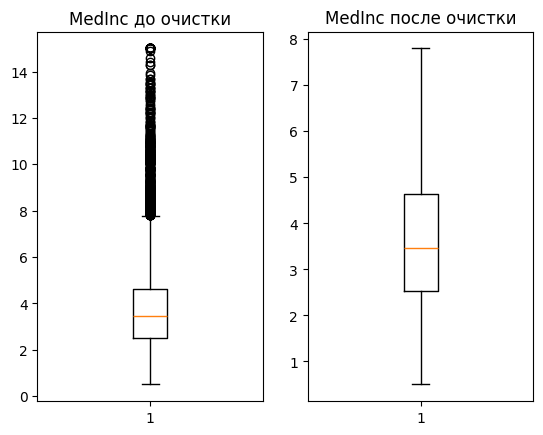

In [161]:
plt.subplot(1, 2, 1)
plt.boxplot(dataset['MedInc'])
plt.title("MedInc до очистки")

plt.subplot(1, 2, 2)
plt.boxplot(dataset_cleaned['MedInc'])
plt.title("MedInc после очистки")

сделаем очистку переменных `Population` и `AveRooms` с помощью z-score:

In [162]:
Z_TRESHOLD = 3
dataset_cleaned['z_score_population'] = np.abs(stats.zscore(dataset_cleaned['Population']))
dataset_cleaned['z_score_averooms'] = np.abs(stats.zscore(dataset_cleaned['AveRooms']))
dataset_cleaned = dataset_cleaned.loc[
    (dataset_cleaned['z_score_population'] < Z_TRESHOLD) & 
    (dataset_cleaned['z_score_averooms'] < Z_TRESHOLD)]

print(f"Количество наблюдений до очистки: {len(dataset)}\nПосле очистки: {len(dataset_cleaned)}")


Количество наблюдений до очистки: 16640
После очистки: 16252


Text(0.5, 1.0, 'AveRooms После очистки')

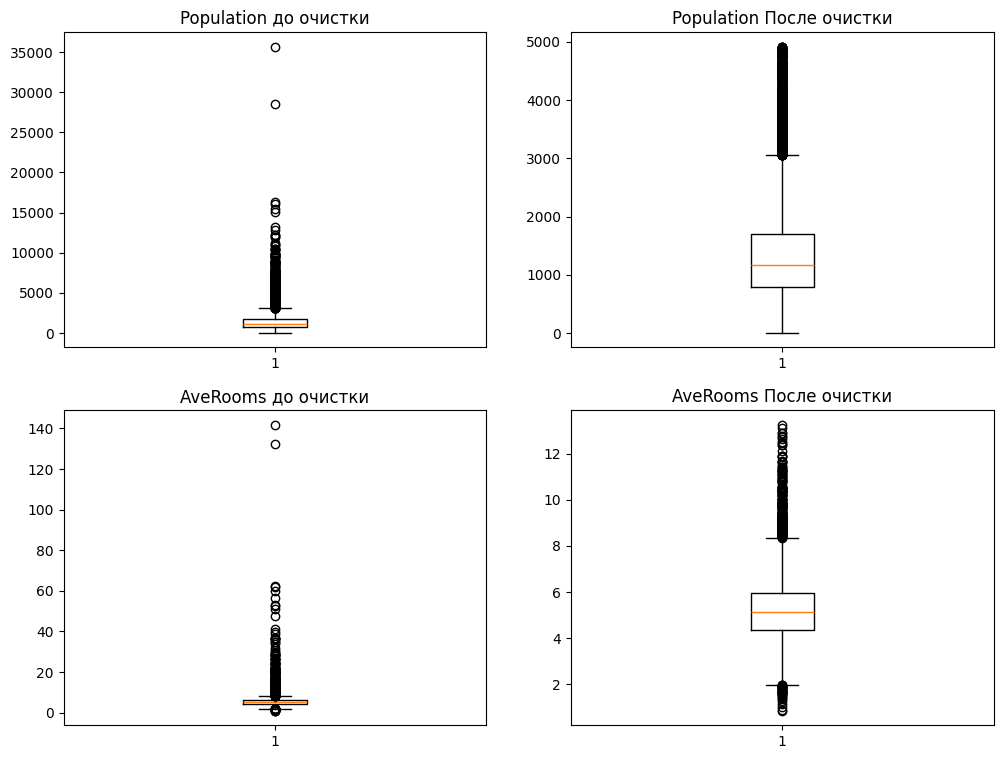

In [163]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
plt.boxplot(dataset['Population'])
plt.title("Population до очистки")

plt.subplot(2, 2, 2)
plt.boxplot(dataset_cleaned['Population'])
plt.title("Population После очистки")

plt.subplot(2, 2, 3)
plt.boxplot(dataset['AveRooms'])
plt.title("AveRooms до очистки")

plt.subplot(2, 2, 4)
plt.boxplot(dataset_cleaned['AveRooms'])
plt.title("AveRooms После очистки")

In [164]:
population_summary = pd.concat([dataset['Population'].describe(), dataset_cleaned['Population'].describe()], axis=1)
population_summary

,Population,Population
count,16640.000000,16252.000000
mean,1436.939123,1350.056178
std,1159.762831,825.182199
min,3.000000,3.000000
25%,792.000000,792.000000
50%,1168.000000,1161.000000
75%,1727.000000,1695.000000
max,35682.000000,4916.000000


In [165]:
averooms_summary = pd.concat([dataset['AveRooms'].describe(), dataset_cleaned['AveRooms'].describe()], axis=1)
averooms_summary

,AveRooms,AveRooms
count,16640.000000,16252.000000
mean,5.396218,5.244772
std,2.648682,1.297523
min,0.846154,0.846154
25%,4.379310,4.370802
50%,5.166053,5.148777
75%,6.000000,5.966644
max,141.909091,13.258824


---

Осуществим отбор признаков:

<Axes: >

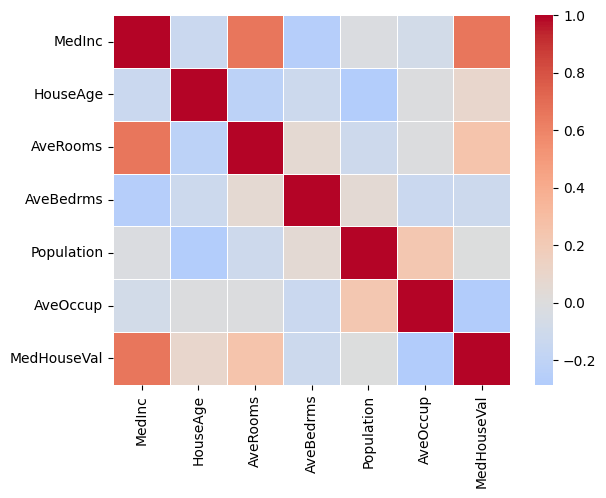

In [166]:
dataset = dataset_cleaned.drop(columns=['z_score_population', 'z_score_averooms', 'Longitude', 'Latitude'])
sns.heatmap(dataset.corr(method="spearman"), cmap="coolwarm", center=0, linewidths=0.5)

Используем жадный алгоритм, которым поочередно добавляются переменные к лучшему набору признаков. В качестве модели берем линейную регрессию:

In [171]:
import pandas as pd
import statsmodels.api as sm

def forward_selection_adj_r2(data, target):

    features = list(data.columns)
    features.remove(target)

    selected = []                # выбранные признаки
    best_adj_r2 = -float('inf')  # текущее лучшее значение скоррект. R²
    best_model = None

    while True:
        scores_with_candidates = []

        for feature in features:
            # строим модель с добавлением одного нового признака
            current_features = selected + [feature]
            X = sm.add_constant(data[current_features])
            y = data[target]
            model = sm.OLS(y, X).fit()
            scores_with_candidates.append((model.rsquared_adj, feature, model))

        # сортируем по скорректированному R² (от большего к меньшему)
        scores_with_candidates.sort(key=lambda x: x[0], reverse=True)
        best_candidate_r2, best_candidate, candidate_model = scores_with_candidates[0]

        # проверяем, улучшился ли скорректированный R²
        if best_candidate_r2 > best_adj_r2:
            selected.append(best_candidate)
            features.remove(best_candidate)
            best_adj_r2 = best_candidate_r2
            best_model = candidate_model
            print(f"Добавлен признак: {best_candidate} | Adj R² = {best_adj_r2:.4f}")
        else:
            break  # улучшений нет → выходим

        # если больше нечего добавлять
        if not features:
            break

    print("\nЛучшие признаки:", selected)
    print(f"Лучший скорректированный R²: {best_adj_r2:.4f}")
    return best_model, selected


In [172]:
best_model, best_features = forward_selection_adj_r2(dataset, "MedHouseVal")

print("\nИтоговая модель:")
print(best_model.summary())

Добавлен признак: MedInc | Adj R² = 0.4467
Добавлен признак: HouseAge | Adj R² = 0.4929
Добавлен признак: AveRooms | Adj R² = 0.5155
Добавлен признак: AveBedrms | Adj R² = 0.5484
Добавлен признак: AveOccup | Adj R² = 0.5509
Добавлен признак: Population | Adj R² = 0.5512

Лучшие признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Population']
Лучший скорректированный R²: 0.5512

Итоговая модель:
                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     3328.
Date:                 Сб, 11 окт 2025   Prob (F-statistic):               0.00
Time:                        01:17:27   Log-Likelihood:                -18641.
No. Observations:               16252   AIC:                         3.730e+04
Df Residuals:                 